In [36]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import time

from auxfunctions import *
from implementations import *

import warnings
warnings.filterwarnings('ignore')

## Ejemplo N nearest neighbours

In [37]:
X = gen_observation_points(2, 10_000, 1)
x = np.array([[0.5,0.9]])

In [38]:
indexes = N_nearest_observations_points(X, x, 1_000)

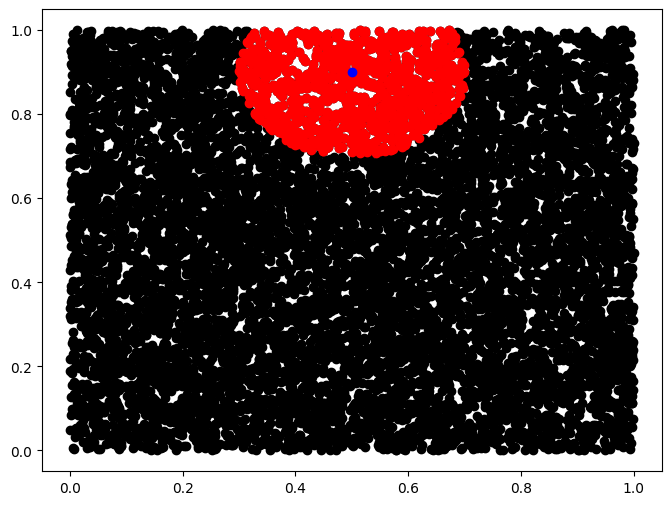

In [39]:
plt.figure(figsize=(8, 6))

plt.scatter(X[:,0], X[:,1], c='k')
plt.scatter(X[indexes,0], X[indexes,1], c='r')
plt.scatter(x[:,0], x[:,1], c='b');

## N vs RMSE, TIME

In [18]:
n_1 = 1_250
n_2 = 1_000
d = 2
sup = 20

nu_1 = 1/2
nu_2 = 3/2
theta_1 = 1
theta_2 = 0.5

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)

In [19]:
X_1, X_2, Y_1, Y_2 = gen_observations(d, n_1, n_2, sup, nu_1, theta_1, nu_2, theta_2, nu_12, theta_12, rho_12)

In [20]:
X_1, X_test, Y_1, Y_test = train_test_split(X_1, Y_1, test_size=0.2)

Train set

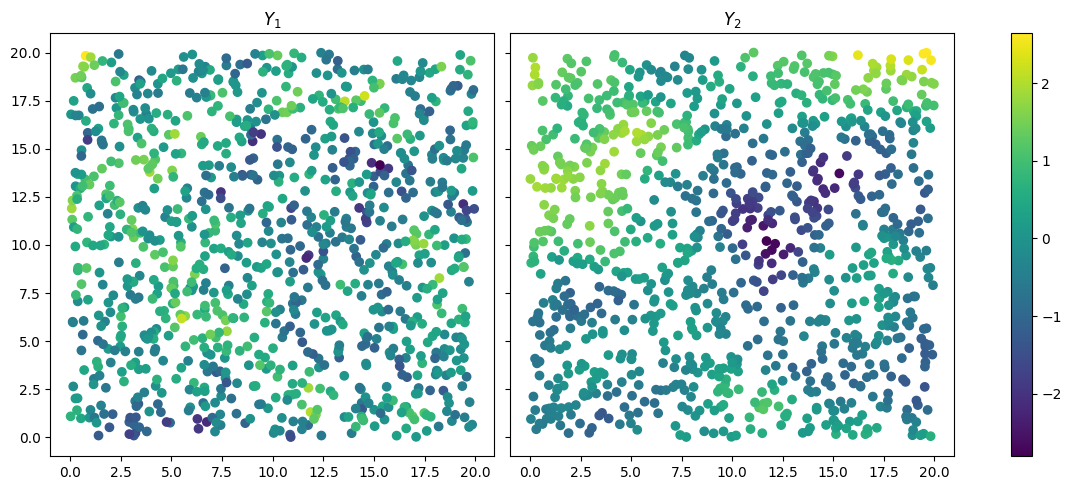

In [21]:
NestedCoKriging(X_1, X_2, Y_1, Y_2, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12).plot_obs()

In [22]:
class coKrigingNN:
    def __init__(self, X_1, X_2, Y_1, Y_2, N, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12):
        check_consistent_dimension(1, X_1, X_2)
        check_consistent_dimension(0, X_1, Y_1)
        check_consistent_dimension(0, X_2, Y_2)
        self.X_1, self.X_2 = X_1, X_2
        self.Y_1, self.Y_2 = Y_1, Y_2
        self.N = N
        
        check_positive_elements(theta_1, theta_2, theta_12, nu_1, nu_2, nu_12)
        self.theta_1 = theta_1
        self.theta_2 = theta_2
        self.theta_12 = theta_12
        self.nu_1 = nu_1
        self.nu_2 = nu_2
        self.nu_12 = nu_12
        self.rho_12 = rho_12
    
    def _predict(self, x):
        indexes_1 = N_nearest_observations_points(self.X_1, x, self.N)
        indexes_2 = N_nearest_observations_points(self.X_2, x, self.N)
        
        sigma = K(self.X_1[indexes_1], self.X_2[indexes_2],
                  matern_model(self.theta_1, self.nu_1),
                  matern_model(self.theta_2, self.nu_2),
                  matern_model(self.theta_12, self.nu_12),
                  self.rho_12)
        c = k(x, self.X_1[indexes_1], self.X_2[indexes_2],
              matern_model(self.theta_1, self.nu_1),
              matern_model(self.theta_12, self.nu_12),
              self.rho_12)    
        return c.T @ np.linalg.solve(sigma, np.concatenate([Y_1[indexes_1], Y_2[indexes_2]]))
    
    def predict(self, X):
        return np.array([self._predict(X[[i]]) for i in range(len(X))])    

In [12]:
times = []
rmses = []
Ns = np.arange(100, X_1.shape[0]+1, 100)
num_iterations = 1

for N in Ns:
    execution_time = 0
    rmse = 0
    for _ in range(num_iterations):
        start_time = time.time()
        
        coK_NN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, 
                             theta_1, theta_2, theta_12,
                             nu_1, nu_2, nu_12, rho_12)
        Y_pred = coK_NN.predict(X_test)
        
        end_time = time.time()
        
        execution_time += end_time - start_time
        rmse += root_mean_squared_error(Y_pred, Y_test)
    
    times.append(execution_time / num_iterations)
    rmses.append(rmse / num_iterations)

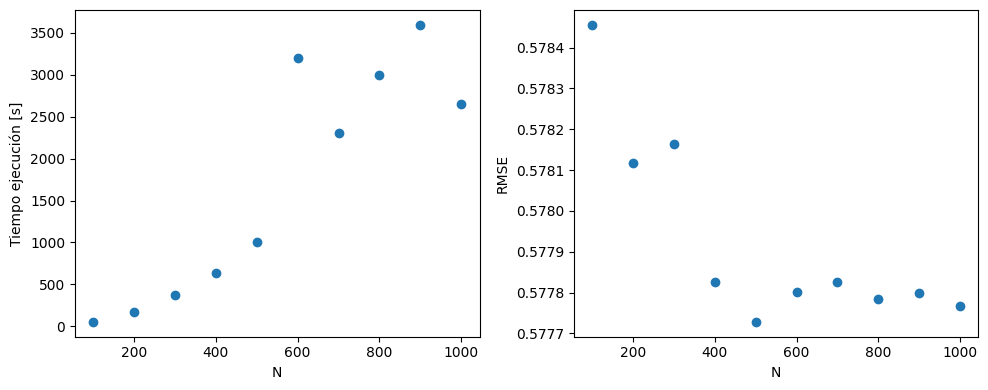

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.scatter(Ns, times)
ax1.set_xlabel('N'); ax1.set_ylabel('Tiempo ejecución [s]')

ax2.scatter(Ns, rmses)
ax2.set_xlabel('N'); ax2.set_ylabel('RMSE')

fig.tight_layout()

In [35]:
coK_NN = coKrigingNN(X_1, X_2, Y_1, Y_2, 10, 
                    theta_1, theta_2, theta_12,
                    nu_1, nu_2, nu_12, rho_12)
Y_pred = coK_NN.predict(X_test)

In [24]:
root_mean_squared_error(Y_pred, Y_test)

0.5061968761303878

In [25]:
NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
A_1 = gen_A(X_1, 10)
A_2 = gen_A(X_2, 10)
y_pred_NcoK = NcoK.predict(X_test, A_1, A_2)

In [26]:
root_mean_squared_error(y_pred_NcoK, Y_test)

0.512517226662035

In [27]:
sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

y_pred_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2,
                 matern_model(theta_1, nu_1),
                 matern_model(theta_12, nu_12), 
                 rho_12, sigma
                 )

In [28]:
root_mean_squared_error(y_pred_coK, Y_test)

0.5050305875635628